# Unsupervised Classification of Multiband Imagery with K-Means  

Geoprocesamiento 2025-1S  
Universidad Nacional de Colombia  
Authors: Alicia Arévalo Robinson and Ricardo Andrés Martinez Soto  
Link to repository:

## 0. Requirements 🗒️

### Import modules

In [11]:
# Standard and scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.windows as rwin
from rasterio.windows import from_bounds

# Machine-learning tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Image-enhancement for visual interpretation
from skimage.exposure import equalize_adapthist

## 1. K-Means

### Load Datasets and generate a working subset


Read image

In [10]:
raster_path = r'./data/image_export3.tif'

Clip image

In [13]:
subset_path = r'./data/image_clip.tif'

min_x, min_y, max_x, max_y = 400000, 130000, 470000, 200000

with rio.open(raster_path) as src:
    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    meta = src.meta.copy()
    meta.update({
        'height': window.height,
        'width': window.width,
        'transform': src.window_transform(window)
    })
    with rio.open(subset_path, 'w', **meta) as dst:
        dst.write(src.read(window=window))

Explore metadata

In [14]:
# --- Print key metadata fields to understand what is stored ---
print("Subset metadata summary:")
print(f"  Dimensions    → {meta['width']} × {meta['height']} px")
print(f"  Band count    → {meta['count']} bands")
print(f"  CRS           → {meta['crs']}")
print(f"  Data type     → {meta['dtype']}")
print(f"  Transform     →\n    {meta['transform']}")

Subset metadata summary:
  Dimensions    → 7000.0 × 7000.0 px
  Band count    → 12 bands
  CRS           → EPSG:32618
  Data type     → uint16
  Transform     →
    | 10.00, 0.00, 400000.00|
| 0.00,-10.00, 200000.00|
| 0.00, 0.00, 1.00|


### Preview the subset in natural colour  

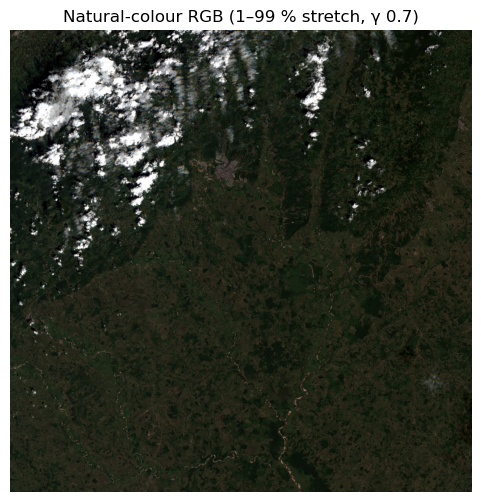

In [15]:
#· RGB preview (bands 4-3-2 )
with rio.open(subset_path) as src:
    img = src.read()

bands_rgb = (4,3,2)                            # R-G-B (1-based)
gamma     = 0.7                                 # contrast tweak

channels = []
for b in bands_rgb:
    band = img[b-1].astype(float)
    lo, hi = np.percentile(band, (1, 99))
    band = np.clip((band - lo) / (hi - lo), 0, 1)
    channels.append(band)

rgb = np.dstack(channels) ** gamma

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("Natural-colour RGB (1–99 % stretch, γ 0.7)")
plt.axis("off")
plt.show()


### The `ClusteredStack` class  


In [16]:
# %% Listings 5-7 completos (adaptados)
class ClusteredStack:
    
    def __init__(self, raster_path): # Initialises the class instance.
        self.raster_path = raster_path # path to the multiband GeoTIFF (e.g., the 400×400 subset).  
        self.model_input = None #    the reshaped data matrix  
        self.height = self.width = self.depth = 0 # image dimensions
        self.k_range = [] # List of all k-values (number of clusters) to evaluate
        self.models = [] # Trained KMeans models for each k; stored for later inspection
        self.predicted_rasters = [] # Cluster label images (reshaped to raster size)
        self.inertia_scores = [] # Inertia values (sum of squared distances within clusters); used for Elbow method
        self.silhouette_scores = [] # Silhouette scores (measure of cluster separation); used for model selection

    
    def set_raster_stack(self):
        """Reads the raster and reshapes it into a format suitable for K-Means."""
        with rio.open(self.raster_path) as src:

            # Read all bands into a 3D NumPy array of shape (bands, rows, cols)
            stack = src.read()

             # Replace any NaN (Not-a-Number) values with zero. Avoids errors during clustering algorithms, which cannot handle NaNs
            stack = np.nan_to_num(stack)   
        # Extract the number of bands, rows, and columns from the raster's shape
        # These values are stored as object attributes for later use
        self.depth, self.height, self.width = stack.shape

        # Reshape the 3D array into a 2D matrix of shape (n_pixels, n_bands)
        # Each row now corresponds to one pixel, and each column to a spectral band
        # Transposition (.T) ensures the matrix has the correct shape for scikit-learn
        self.model_input = stack.reshape(self.depth, -1).T


    def build_models(self, k_values):
        """
            Trains one K-Means clustering model for each value of k provided in k_values.
         It stores the resulting models, cluster labels, and evaluation metrics.
        """

        # Convert the input iterable into a list and store it
        # This list defines the number of clusters to be tested (e.g. [3, 4, 5, ..., 10])
        self.k_range = list(k_values)

        # Initialise empty lists to store models, results, and metrics
        self.models, self.predicted_rasters = [], [] # Trained KMeans objects  - Cluster label images (reshaped to raster form)
        self.inertia_scores, self.silhouette_scores = [], [] # Inertia values for each k - # Silhouette scores for each k

        for k in self.k_range:

            # Create a KMeans model with k clusters
            # random_state ensures reproducibility; n_init specifies how many times the algorithm will run with different centroid seeds
            km = KMeans(n_clusters=k, random_state=42, n_init=10)

             # Fit the model to the reshaped raster and predict the cluster labels
             # This returns one label (cluster ID) per pixel
            labels = km.fit_predict(self.model_input)

            # Store the trained model
            self.models.append(km)

            # Record the inertia for this k (lower is better; used in Elbow method)
            self.inertia_scores.append(km.inertia_)

            # Calculate and store the silhouette score for this k
            # A higher silhouette score indicates better-defined clusters
            # Sampling is limited to 1000 points for performance reasons
            self.silhouette_scores.append(
                silhouette_score(self.model_input, labels, sample_size=1000)
            )

            # Reshape the flat list of labels back to image form (rows × cols)
            # This is required for visualising the classified image later
            self.predicted_rasters.append(labels.reshape(self.height, self.width))


    def show_clustered(self, cmap="Accent"):
        """
        Displays one classified raster image for each value of k.
        Each image uses a categorical colourmap for easy interpretation.
        """
        for k, img_cls in zip(self.k_range, self.predicted_rasters):
            plt.figure(figsize=(5, 5))
            plt.imshow(img_cls, cmap=cmap)
            plt.title(f"{k} clusters")
            plt.axis("off")
            plt.colorbar()
            plt.show()

    def show_inertia(self):
        """
        Plots the inertia values for each k to apply the Elbow method.
        Inertia measures how tightly the data points are clustered around their centroids.
        Lower values indicate more compact clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.inertia_scores, "o-")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Inertia")
        plt.title("Elbow method")
        plt.show()

    def show_silhouette(self):
        """
        Plots the silhouette scores for each k to assess clustering quality.
        Silhouette score ranges from -1 to 1, with higher values indicating
        better-defined, well-separated clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.silhouette_scores, "o-")
        plt.xlabel("Número de clusters (k)")
        plt.ylabel("Silhouette Coeff.s")
        plt.title("Silhouette scores")
        plt.show()


In [17]:
# ==== Model training and visualisation (tutorial-style layout) ====

# 1. Instantiate the object
# This creates an instance of the ClusteredStack class using the clipped raster
clustered_models = ClusteredStack(subset_path)

# Load the raster and reshape it into a 2D array of pixels × bands
clustered_models.set_raster_stack()

# 2. Define the range of k values (number of clusters to evaluate)
# Equivalent to testing k = 3, 4, ..., 10
ranges = np.arange(3, 11, 1)

# 3. Train the models
# For each k, this will:
# - Fit a KMeans model
# - Store the predicted labels
# - Compute inertia and silhouette scores
clustered_models.build_models(ranges)

# 4. Display the RGB preview again
# This step is optional but helps visually link the original image with the results
with rio.open(subset_path) as src:
    rgb_preview = src.read()                 # (bands, rows, cols)

plt.figure(figsize=(4,4))
plt.imshow(rgb)
plt.title("RGB (stretch 1-99 % por banda + gamma 0.7)")
plt.axis("off")
plt.show()

clustered_models.show_clustered()
clustered_models.show_inertia()

# --- Alias para mantener el nombre del tutorial ---
ClusteredStack.show_silhouette_scores = ClusteredStack.show_silhouette
clustered_models.show_silhouette_scores()


KeyboardInterrupt: 